# Introduction
This notebook predicts the frequency (measured by daily number) and length of solar flares. Any feedback is welcome and appreciated! <br><br>
See the two cells below to get started.

In [8]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as pyplot
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools

import sklearn
import sklearn.model_selection as skms
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print("Setup Complete")

Setup Complete


## XGBoost Model 

In [9]:
def score_dataset(X_train, y_train, X_test, y_test):
    # low learning rate and many rounds to prevent underfitting
    model = XGBRegressor(eval_metric='mae',n_estimators=5000, learning_rate = 0.05)
    # early_stopping_rounds to prevent overfitting
    model.fit(X_train, y_train, early_stopping_rounds = 8, eval_set = [(X_test, y_test)], verbose=False)
    predictions = model.predict(X_test)
    # mae, predictions for each X_test
    return mean_absolute_error(y_test, predictions), predictions # mean_absolute_error metric

# 1. Predict Solar Flare Peak to End Time

### Feature Engineering and Data Preprocessing

In [10]:
# read data
path = "kaggle/input/instruments-solarflares/flares_and_instruments_v2.csv"
df = pd.read_csv(path, header=0, index_col=0) 
# format time data from string to datetime
df['JJJ Start'] = pd.to_datetime(df['JJJ Start'])
df['JJJ Peak'] = pd.to_datetime(df['JJJ Peak'])
df['JJJ End'] = pd.to_datetime(df['JJJ End'])
# Feature engineering using the time between Start and Peak to help predict "Peak to end" time
df['time to peak'] = (df['JJJ Peak'] - df['JJJ Start']).dt.seconds
df['peak to end'] = (df['JJJ End'] - df['JJJ Peak']).dt.seconds # predicting this with the model later
# Feature engineering #2 (time difference between current flare and last)
arr = np.zeros(12455) # initialize array
for i in range(1, len(arr)): # compute differences
    arr[i] = arr[i] + (df['JJJ Peak'][i] - df['JJJ Peak'][i-1]).seconds
arr[0] = np.mean(arr) 
# set column
df['diff time'] = arr 
# don't include columns that are already represented or can't be known at time of prediction
df = df.drop(['JJJ End', 'JJJ Start', 'JJJ Peak'], axis=1) 
# display data
df.head()

,JJJ Class,HHH X-pos,HHH y-pos,AAA lo,AAA hi,AAA X-pos,AAA Y-pos,AAA,BBB,CCC,DDD,EEE,FFF,GGG,time to peak,peak to end,diff time
Sol,,,,,,,,,,,,,,,,,
20100501_013400,C5.7,-859.938,396.548,0,0,0.000,0.000,0,1,1,0,0,0,0,300,240,14022.310719
20100501_052300,B1.6,-853.902,372.857,0,0,0.000,0.000,0,1,1,0,0,0,0,240,240,13680.000000
20100501_094800,B1.0,-844.986,414.768,6,12,-843.725,416.127,1,1,1,0,0,0,0,180,60,15840.000000
20100502_060300,B2.9,-762.324,417.038,12,25,-904.379,-329.361,1,1,1,0,0,0,0,360,0,73080.000000
20100502_100200,B3.8,231.697,-479.705,0,0,0.000,0.000,0,1,1,0,0,1,0,420,0,14400.000000


The features (besides the ones I "engineered") are described in "flares_and_instruments_v2.csv" on the database's home page. They measure details about the solar flares (like class and position) and the instruments used for observing them. 

In [11]:
# transform "JJJ Class" values from categorical to numerical
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[['JJJ Class']]))
OH_cols.index = df.index
df = df.drop(['JJJ Class'], axis=1) # replaced by columns with numerical values
df = pd.concat([df, OH_cols], axis=1)
df.head() # show (1 if the flare fits the "class")

,HHH X-pos,HHH y-pos,AAA lo,AAA hi,AAA X-pos,AAA Y-pos,AAA,BBB,CCC,DDD,...,261,262,263,264,265,266,267,268,269,270
Sol,,,,,,,,,,,,,,,,,,,,,
20100501_013400,-859.938,396.548,0,0,0.000,0.000,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100501_052300,-853.902,372.857,0,0,0.000,0.000,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100501_094800,-844.986,414.768,6,12,-843.725,416.127,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100502_060300,-762.324,417.038,12,25,-904.379,-329.361,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20100502_100200,231.697,-479.705,0,0,0.000,0.000,0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df.describe() # show statistics

,HHH X-pos,HHH y-pos,AAA lo,AAA hi,AAA X-pos,AAA Y-pos,AAA,BBB,CCC,DDD,...,261,262,263,264,265,266,267,268,269,270
count,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,12455.000000,...,12455.000000,12455.000000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000,12455.00000
mean,-22.511579,7.134955,8.382015,18.245283,-24.107705,-20.782276,0.530871,0.556724,0.119069,0.078683,...,0.000161,0.000241,0.00008,0.00008,0.00008,0.00008,0.00008,0.00008,0.00008,0.00008
std,686.613488,274.779200,14.587570,38.753481,687.864651,484.137024,0.499066,0.496792,0.323882,0.269255,...,0.012671,0.015519,0.00896,0.00896,0.00896,0.00896,0.00896,0.00896,0.00896,0.00896
min,-974.426000,-972.409000,0.000000,0.000000,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,-727.678500,-245.565000,0.000000,0.000000,-272.418500,-126.752500,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,-32.200500,83.280800,6.000000,12.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,686.220500,234.901500,12.000000,25.000000,226.022500,151.806000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,974.652000,699.294000,300.000000,800.000000,1026.540000,987.971000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


### Train Test Split

In [13]:
# predicting 'peak to end' (include in y, not X)
X, y = df.drop(['peak to end'], axis=1), df['peak to end']
# 80% for training, 20% for test data
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, train_size=0.8, test_size=0.2)

### Results

In [14]:
# make predictions using XGBoost
mae, predictions = score_dataset(X_train, y_train, X_test, y_test)
print('MAE %.2f' % mae) # Mean absolute error to two decimal places

MAE 378.51


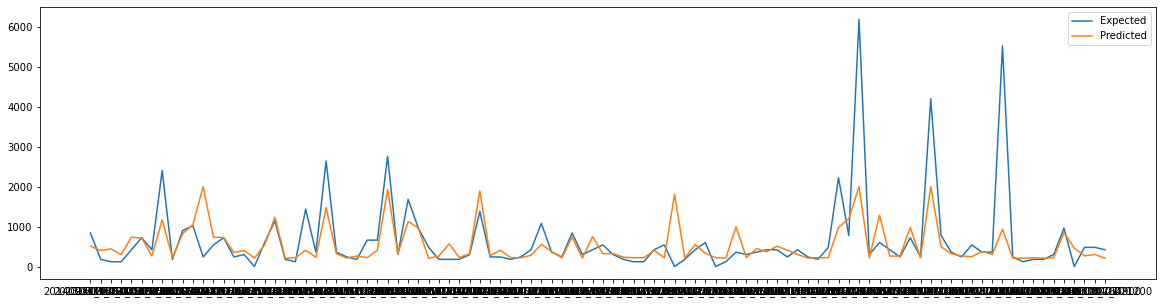

In [15]:
# Visualize the results
plot_y_test = y_test[:100] # first 100 correct ones
plot_predictions = predictions[:100] # first 100 predictions
pyplot.figure(figsize=(20, 5))
pyplot.plot(plot_y_test, label = 'Expected')
pyplot.plot(plot_predictions, label='Predicted')
pyplot.legend()
pyplot.show() # show

# 2. Predict Solar Flare Frequency

### Data Preprocessing

In [16]:
# read data
path = "kaggle/input/instruments-solarflares/flares_and_instruments_v2.csv"
df = pd.read_csv(path, header=0, index_col=0)
# organize data by solar flares per day
time = pd.to_datetime(df['JJJ Start'])
df = time.groupby(time.dt.floor('d')).size()
# show data
df.head()

JJJ Start
2010-05-01    3
2010-05-02    7
2010-05-03    4
2010-05-04    8
2010-05-05    9
Name: JJJ Start, dtype: int64

### Exploratory Data Analysis

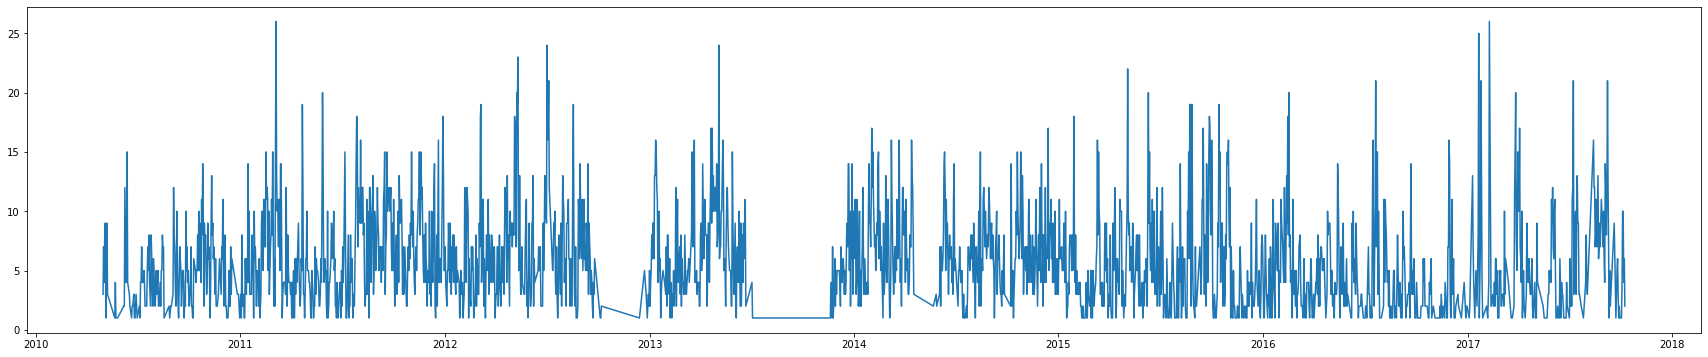

In [17]:
# Number of solar flares vs. Time
pyplot.figure(figsize=(30, 6))
pyplot.plot(df)

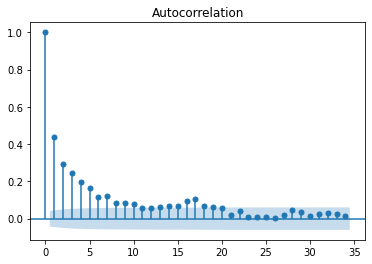

In [18]:
# How many past days are correlated with prediction for current day
plot_acf(df)
pyplot.show()

### Train Test Split

In [19]:
features = [] # organizing the features
n_in = 7 
# Shift the data so that the last 7 days are features for the current day
for i in range(n_in, 0, -1):
    features.append(df.shift(i))
features.append(df.shift(0))
# combine the features
df = pd.concat(features, axis=1)
# drop rows with missing values
df.dropna(inplace = True)
# Prediction (y) is last feature; exclude it from X
X, y = df.values[:, :-1], df.values[:, -1]
# 80% training data, 20% for test data
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, train_size=0.8, test_size=0.2)

### Results

In [20]:
# make predictions using XGBoost
mae, predictions = score_dataset(X_train, y_train, X_test, y_test)
print('MAE %.2f' % mae) # Mean absolute error to two decimal places

MAE 2.69


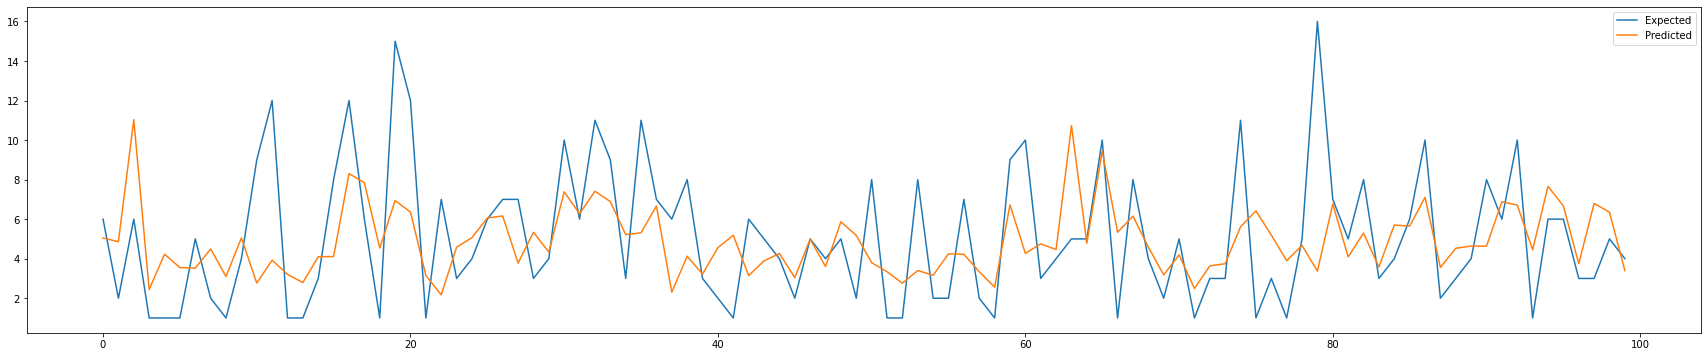

In [21]:
# Visualize the results
pyplot.figure(figsize=(30, 6))
plt_y_test = y_test[:100] # first 100 correct ones
plt_predictions = predictions[:100] # first 100 predictions
pyplot.plot(plt_y_test, label='Expected')
pyplot.plot(plt_predictions, label='Predicted')
pyplot.legend()
pyplot.show()